# Gamma Ray Bursts

Here I do not have target labels, thus mine will be an unsupervised analysis.\
I am searching for a way to cluster my data based on the similarity of the features.\ 
First I will analyze the features and extract from them as much information as I can (summary statistics and hyperparameters)\
Then I will try yo cluster the data using more features at a time.

In [1]:
import sys
sys.path.append(r"C:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks\venv\Utilities\utils.py")
from Utilities import plot_settings
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MeanShift
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

from scipy.stats import norm

In [10]:
import requests

# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names = np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

C:\Users\ricca\AppData\Local\Temp\ipykernel_4420\3973052632.py:9: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=50000`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an example on how to do this.  If you wish to ignore this warning, use `warnings.filterwarnings`.  This warning is expected to be removed in the future and is given only once per `loadtxt` call.
  data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')


In [11]:
T90  = data[6]
T90_err = data[7]
F    = data[9]
Ferr = data[10]
R    = data[11] 

In [12]:
def mask(X):
    # Elimina righe che contengono la stringa '-999'
    mask_valid = ~np.any(X == '-999', axis=1)
    Y = X[mask_valid]

    # Converte in float
    Y = Y.astype(float)

    # Elimina righe che contengono zero
    mask_nonzero = ~np.any(Y == 0.0, axis=1)
    Y_clean = Y[mask_nonzero]

    return Y_clean, Y_clean.shape[0]

In [23]:
X = np.vstack([F, Ferr, T90, T90_err]).T
Y, size = mask(X)

I want to look at relative errors

Text(0, 0.5, 'Flux ')

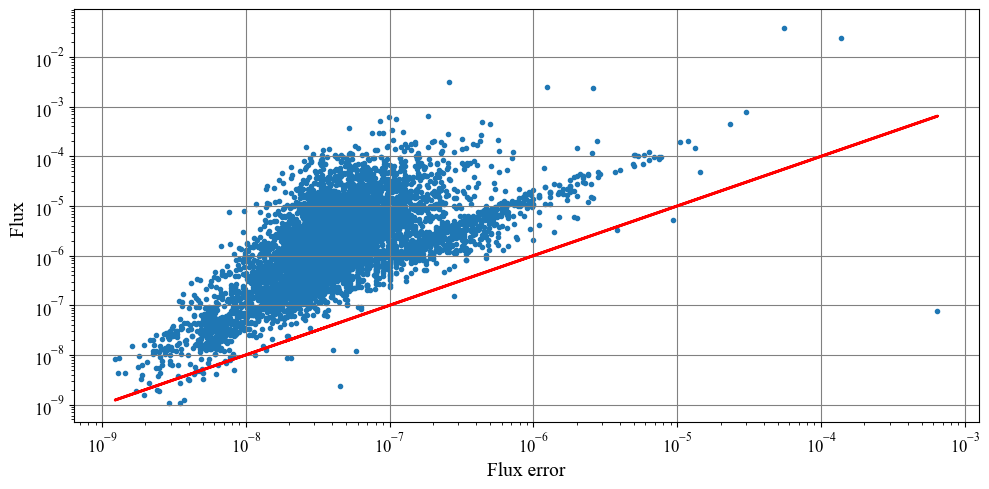

In [24]:
plt.scatter(Y.T[1], Y.T[0], marker='.')
plt.plot(Y.T[1], Y.T[1], lw=2, color='red')
plt.loglog()
plt.xlabel('Flux error')
plt.ylabel('Flux ')

Text(0, 0.5, 'T_90 ')

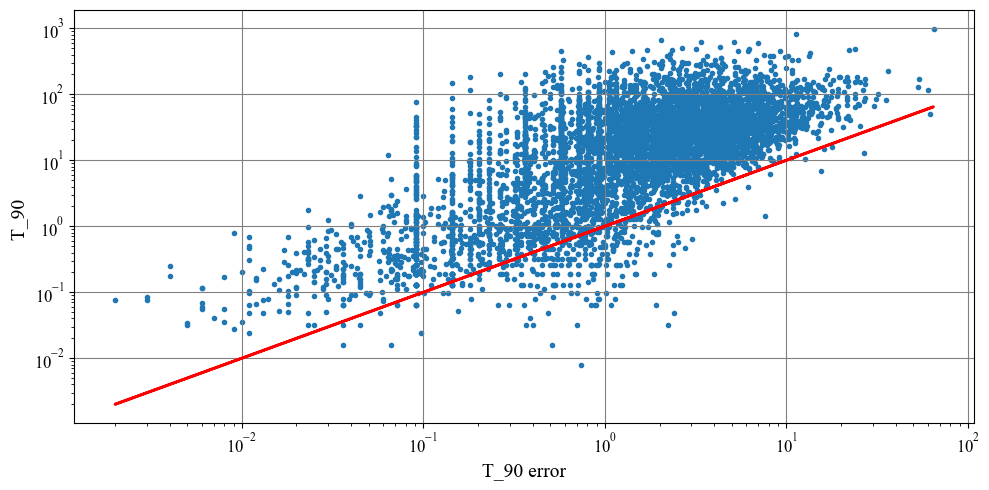

In [25]:
plt.scatter(Y.T[3], Y.T[2], marker='.')
plt.plot(Y.T[3], Y.T[3], lw=2, color='red')
plt.loglog()
plt.xlabel('T_90 error')
plt.ylabel('T_90 ')

All of the points appearing under the red line exhibit relative error bigger then 100%, thus they have to be discarded.\
I can also see a weird effect: there are points lying on lines parallel to the y axis with a $T_{90}$ value ranging from 0.1 to 100! This cannot be an effect of the measurement apparatus, unless given a $T_{90}$ value, fluence (and thus counting statistic) can vary so much that the error attributed to GRBs with very different $T_{90}$ values could be the same.\
I'll look now into the 1D distributions of T90 and fluence.

In [33]:
def mask2(X):
    # Elimina righe con valori mancanti '-999'
    mask_valid = ~np.any(X == '-999', axis=1)
    Y = X[mask_valid].astype(float)

    # Elimina righe con zeri
    mask_nonzero = ~np.any(Y == 0.0, axis=1)
    Y = Y[mask_nonzero]

    # Filtro: errore minore o uguale al valore misurato
    F, Ferr, T90, T90_err = Y.T  # unpack colonne
    mask_err_valid = (Ferr <= F) & (T90_err <= T90)

    Y_clean = Y[mask_err_valid]

    return Y_clean, Y_clean.shape[0]

In [84]:
X = np.vstack([F, Ferr, T90, T90_err]).T
Y, size = mask2(X)

## Gaussian mixtures

Text(0, 0.5, 'Density')

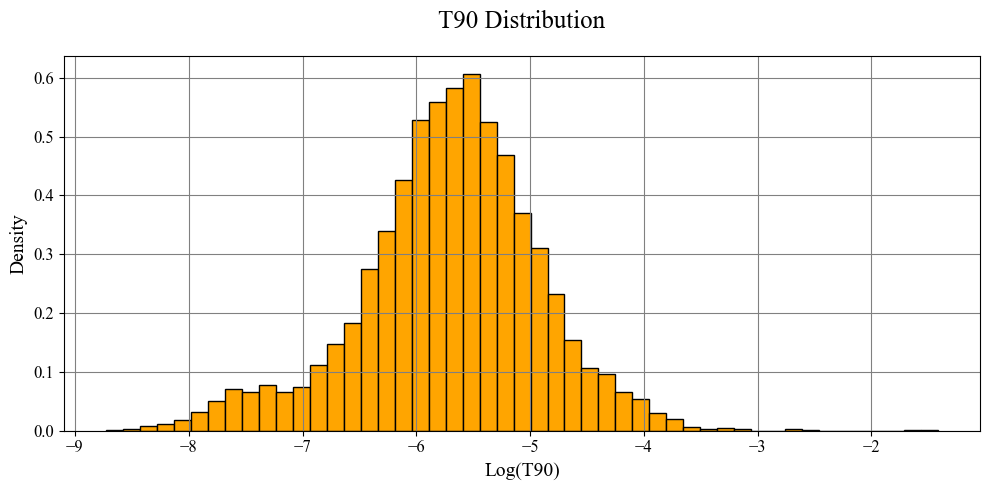

In [49]:
_,_,_ = plt.hist(np.log10(Y.T[0]), bins='scott', density=True, histtype='barstacked', color='orange', edgecolor='black')
plt.title('T90 Distribution')
plt.xlabel('Log(T90)')
plt.ylabel('Density')

In [51]:
n_range = range(2,7) # Test 30 bandwidths from 0.1 to 1.0
K = 5 # Do 5-fold cross validation
grid = GridSearchCV(GaussianMixture(), {'n_components': n_range}, cv= K, scoring=GaussianMixture.aic) # Try each bandwidth with K-folds
grid.fit(Y) #Fit the histogram data that we started the lecture with.

GridSearchCV(cv=5, estimator=GaussianMixture(),
             param_grid={'n_components': range(2, 7)},
             scoring=<function GaussianMixture.aic at 0x000001F9F646CD60>)

In [52]:
estimator = grid.best_estimator_

In [53]:
estimator.fit(np.log10(Y.T[0]).reshape(-1,1))

GaussianMixture(n_components=2)

Text(0, 0.5, 'Density')

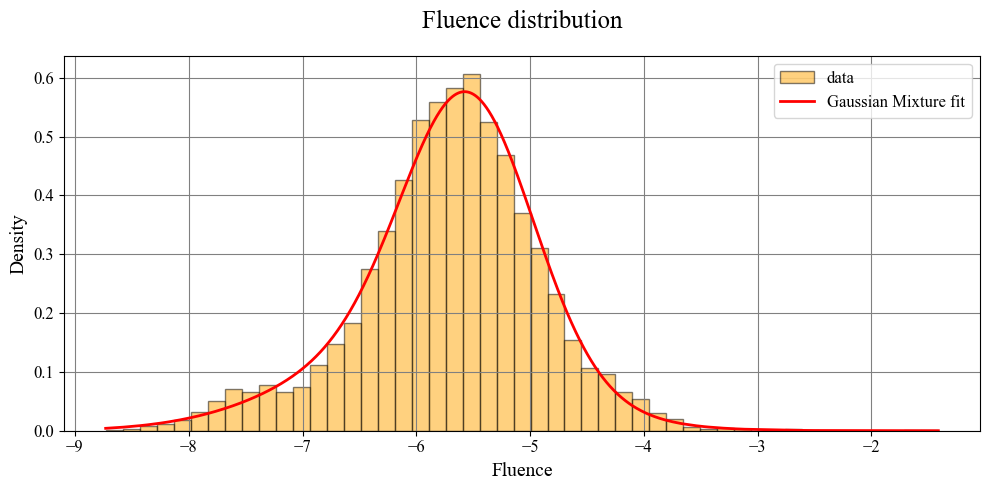

In [54]:
_,_,_ = plt.hist(np.log10(Y.T[0]), bins='scott', density=True, histtype='barstacked', color='orange', edgecolor='black', alpha=0.5, label='data')
x = np.sort(np.log10(Y.T[0]))
y = np.exp(estimator.score_samples(x.reshape(-1,1)))
plt.plot(x, y, lw=2, color='red', label='Gaussian Mixture fit')
plt.legend()
plt.title('Fluence distribution')
plt.xlabel('Fluence')
plt.ylabel('Density')

In [248]:
estimator.fit(np.log10(Y.T[2]).reshape(-1,1))

GaussianMixture(n_components=2)

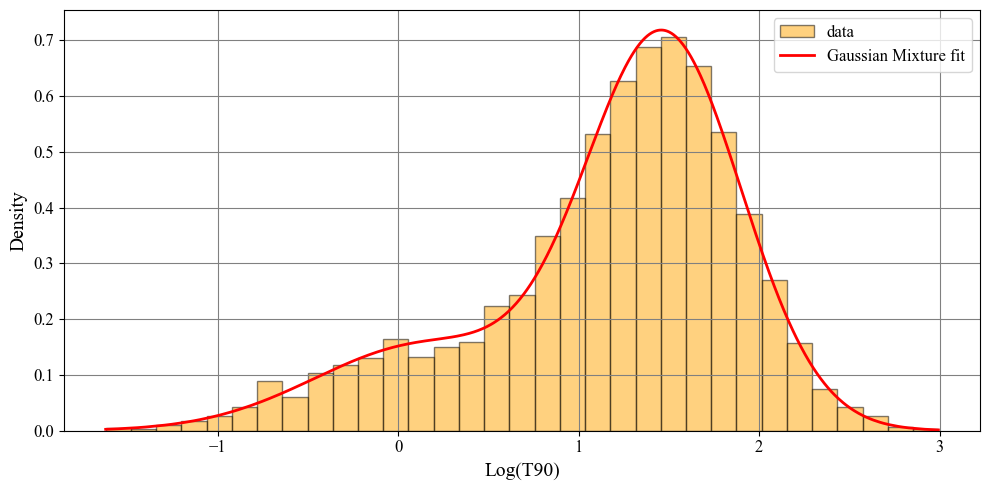

In [249]:
_,_,_ = plt.hist(np.log10(Y.T[2]), bins='scott', density=True, histtype='barstacked', color='orange', edgecolor='black', alpha=0.5, label='data')
x = np.sort(np.log10(Y.T[2]))
y = np.exp(estimator.score_samples(x.reshape(-1,1)))
plt.plot(x, y, lw=2, color='red', label='Gaussian Mixture fit')
plt.ylabel('Density')
plt.xlabel('Log(T90)')
plt.legend()

**What variable(s) shows the multi-modality more evidently?**\
It is evident that the feature showing multi-modality is $T_{90}$. 

In [263]:
from scipy.interpolate import interp1d
from scipy.optimize import brentq

def find_intersection(x, y1, y2):
    """
    Find the intersection point of two lines defined by their y-intercepts and a point on each lin
    Parameters:
    x (float): The x-coordinate of the point where the two lines intersect
    y1 (float): The y-intercept of the first line
    y2 (float): The y-intercept of the second line
    Returns:
    float: The y-coordinate of the intersection point
    """
    
    diff_interp = interp1d(x, y1 - y2, kind='linear', fill_value="extrapolate")

    a, b = x[0], x[-1]
    if diff_interp(a) * diff_interp(b) >= 0:
        raise ValueError("No sign change in interval. Try narrowing the interval or checking data.")

    root = brentq(diff_interp, a, b)

    return root

In [264]:
from scipy.stats import norm

In [327]:
n1 = norm(loc=estimator.means_[0][0],scale=estimator.covariances_[0][0][0])
n2 = norm(loc=estimator.means_[1][0],scale=estimator.covariances_[1][0][0])
root = find_intersection(np.log10(Y.T[2]), estimator.weights_[1]*n2.pdf(np.log10(Y.T[2])),estimator.weights_[0]*n1.pdf(np.log10(Y.T[2])))

In [329]:
labels = estimator.predict(np.log10(Y.T[2]).reshape(-1,1))

In [330]:
thresholds = np.logspace(min(np.log10(Y.T[2])), max(np.log10(Y.T[2])), 100)

counts = {
    'below': {'red': [], 'blue': []},
    'above': {'red': [], 'blue': []}
}

for thresh in thresholds:
    mask_below = np.log10(Y.T[2]) < thresh
    mask_above = np.log10(Y.T[2]) >= thresh

    counts['below']['red'].append(np.sum((labels == 1) & mask_below))
    counts['below']['blue'].append(np.sum((labels == 0) & mask_below))
    counts['above']['red'].append(np.sum((labels == 1) & mask_above))
    counts['above']['blue'].append(np.sum((labels == 0) & mask_above))
    
counts['below']['red'] = np.array(counts['below']['red'])
counts['below']['blue'] = np.array(counts['below']['blue'])
counts['above']['red'] = np.array(counts['above']['red'])
counts['above']['blue'] = np.array(counts['above']['blue'])

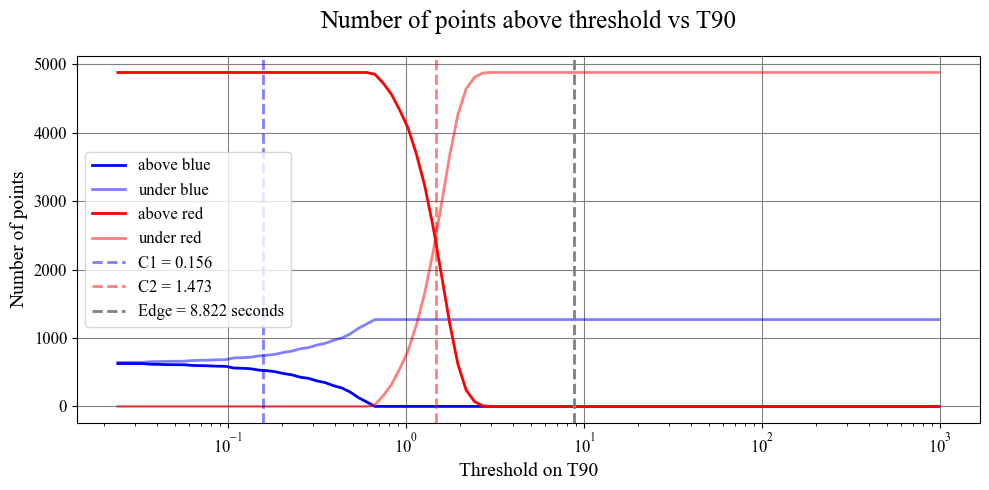

In [334]:
plt.plot(thresholds, counts['above']['blue'], label='above blue', color='blue', alpha=1)
plt.plot(thresholds, counts['below']['blue'], label='under blue', color='blue', alpha=0.5)
plt.plot(thresholds, counts['above']['red'], label='above red', color='red', alpha=1)
plt.plot(thresholds, counts['below']['red'], label='under red', color='red', alpha=0.5)
plt.axvline(estimator.means_[0][0], 0, 1, color='blue', linestyle='--', alpha=0.5, label=f'C1 = {estimator.means_[0][0]:.4}')
plt.axvline(estimator.means_[1][0], 0, 1, color='red', linestyle='--', alpha=0.5, label=f'C2 = {estimator.means_[1][0]:.4}')
plt.axvline(10**root, 0, 1, color='grey', linestyle='--', lw=2, alpha=1, label=f'Edge = {10**root:.4} seconds')
plt.xlabel('Threshold on T90')
plt.ylabel('Number of points')
plt.xscale('log')
plt.title('Number of points above threshold vs T90')
plt.legend()

**What's the threshold between the classes?**\
$T_{90}$ edge is at $8.882$ seconds

In [87]:
A = np.vstack([Y.T[0],Y.T[2]]).T

In [88]:
gm = GaussianMixture(2, random_state=42)
gm.fit(A)
labels = gm.predict(A)

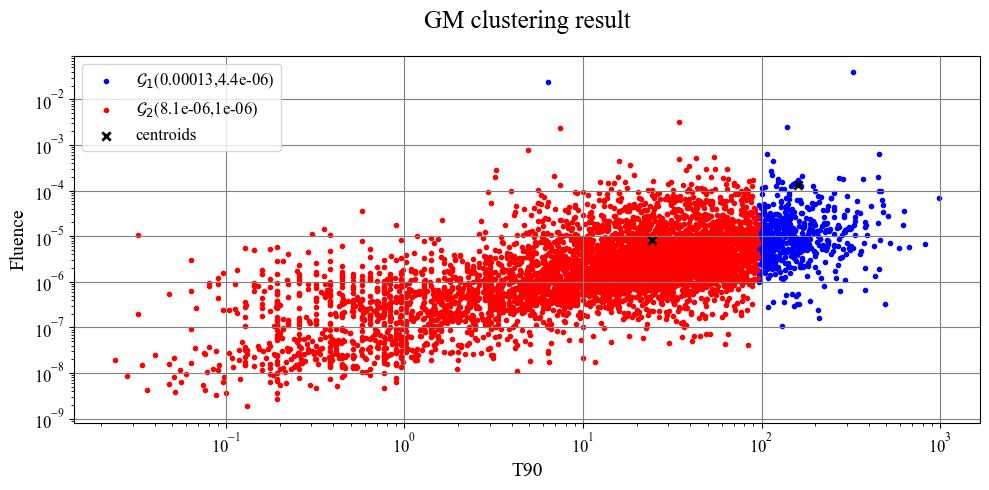

In [92]:
plt.scatter(A.T[1][labels==0],A.T[0][labels==0],marker='.', color='blue', label=r"$\mathcal{G}_1$"+f'({gm.means_[0][0]:.2},{gm.covariances_[0][0][0]:.2})')
plt.scatter(A.T[1][labels==1],A.T[0][labels==1],marker='.', color='red',  label=r"$\mathcal{G}_2$"+f'({gm.means_[1][0]:.2},{gm.covariances_[1][0][0]:.2})')
plt.scatter(gm.means_[:,1],gm.means_[:,0], marker='x', color='black', label='centroids')
plt.loglog()
plt.xlabel('T90')
plt.ylabel('Fluence')
plt.title('GM clustering result')
plt.legend()

In [93]:
print(f'Cluster 1:  G({gm.means_[0]}, {np.diag(gm.covariances_[0])})')
print(f'Cluster 2:  G({gm.means_[1]}, {np.diag(gm.covariances_[1])})')

Cluster 1:  G([1.30135211e-04 1.60466407e+02], [4.44628462e-06 1.06243068e+04])
Cluster 2:  G([8.07631311e-06 2.42965048e+01], [1.00305223e-06 5.48534860e+02])


**Does the distribution contain different sub-populations? How many?**\
Using GM I found two sub distributions:
 1. Short GRBs with a mean time of $24.44 s$ and a mean fluence of $7.04\times10^{-6} \frac{\text{erg}}{\text{cm}^2}$
 2. Long GRBs with a mean time of $178.31 s$ and a mean fluence of $9.75\times10^{-5} \frac{\text{erg}}{\text{cm}^2}$
 
Thus longer GRBs are more frequent then shorter ones.

## K-Means

In [94]:
n_range = range(2,7) # Test 30 bandwidths from 0.1 to 1.0
K = 5 # Do 5-fold cross validation
grid = GridSearchCV(KMeans(), {'n_clusters': n_range}, cv= K, scoring=KMeans.score) # Try each bandwidth with K-folds
grid.fit(A) #Fit the histogram data that we started the lecture with.

GridSearchCV(cv=5, estimator=KMeans(), param_grid={'n_clusters': range(2, 7)},
             scoring=<function _BaseKMeans.score at 0x000001F9F5D7DBC0>)

In [96]:
km = KMeans(n_clusters=2, random_state=42)
labels = km.fit_predict(A)

In [97]:
x_greens = A.T[0][labels == 0]
y_greens = A.T[1][labels == 0]
x_red = A.T[0][labels == 1]
y_red = A.T[1][labels == 1]

Text(0.5, 1.0, 'Clustering result')

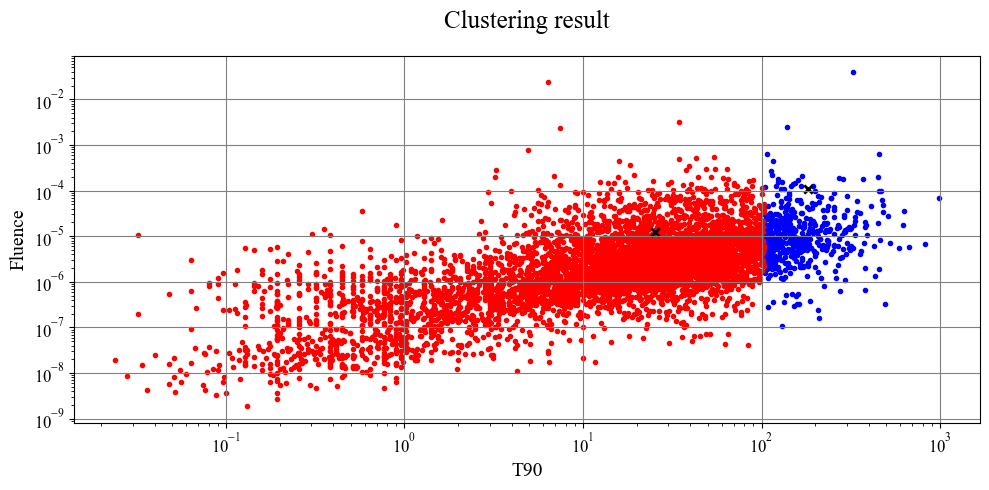

In [98]:
plt.scatter(y_greens, x_greens, marker='.', color='blue')
plt.scatter(y_red, x_red, marker='.', color='red')
plt.scatter(km.cluster_centers_[:,1], km.cluster_centers_[:,0], marker='x', color='black')
plt.xlabel('T90')
plt.ylabel('Fluence')
plt.loglog()
plt.title('Clustering result')

In [99]:
for i,a in enumerate(['Fluence', 'T90']):
    print(a)
    for l,c,m in zip(['Short GRBs','Long GRBs'],np.sort(km.cluster_centers_[:,i]),np.sort(gm.means_[:,i])):
        print(l,": ", c,m, np.abs(c-m)/np.mean([c,m]) )
        

Fluence
Short GRBs :  1.2629067298427306e-05 8.076313108646793e-06 0.4397653267191402
Long GRBs :  0.00010745234607287445 0.00013013521091089408 0.19094320532593617
T90
Short GRBs :  25.249807563173682 24.29650477681405 0.0384812811019335
Long GRBs :  182.42402834008078 160.4664071571752 0.1280736871593567


## Mean-shift

In [27]:
inertia = []
k_range = np.power(10, np.linspace(-4,1,5))

for k in k_range:
    print(k)
    ms = MeanShift(bandwidth=k)
    inertia.append(silhouette_score(Y, ms.fit_predict(Y)))

0.0001
0.0017782794100389228
0.03162277660168379
0.5623413251903491
10.0


Best k is 0.03162277660168379


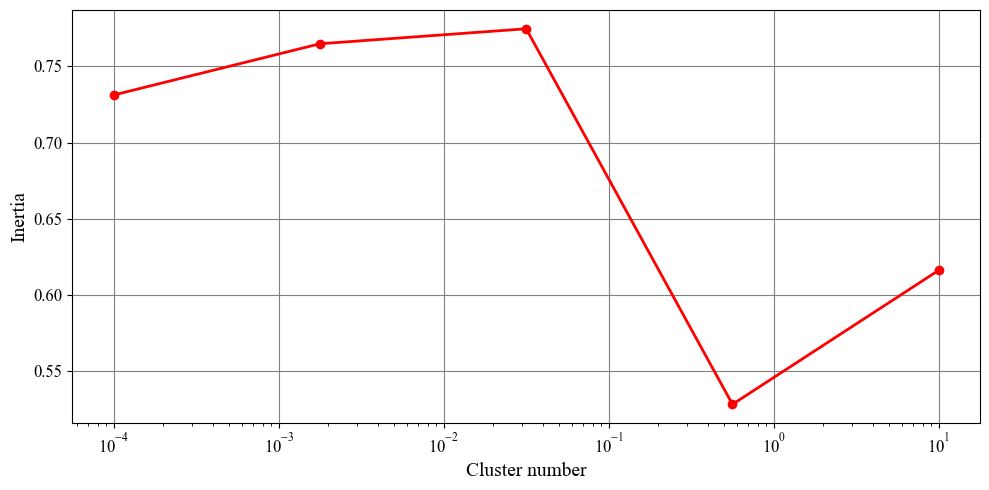

In [31]:
plt.plot(k_range, inertia, marker='o', color='red')
plt.xlabel('Cluster number')
plt.ylabel('Inertia')
plt.xscale('log')

best_k = k_range[np.argmax(inertia)]
print('Best k is', best_k)

In [ ]:
ms = MeanShift()
labels = ms.fit_predict(Y)

In [42]:
cluster_centers = ms.cluster_centers_
n_clusters = len(np.unique(labels))

In [43]:
cluster_centers.size

30

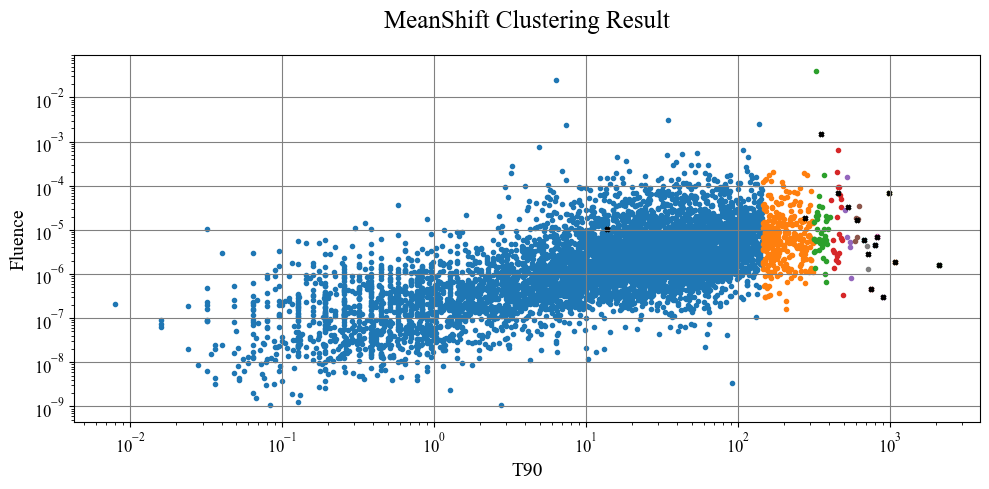

In [46]:
for i in range(n_clusters):
    plt.scatter(Y.T[1][labels == i], Y.T[0][labels == i], marker='.', label=f'Cluster {i}')

# Plot cluster centers
plt.scatter(cluster_centers[:, 1], cluster_centers[:, 0], 
            color='black', marker='x', s=10, label='Centroids')

plt.xlabel('T90')
plt.ylabel('Fluence')
plt.loglog()
plt.title('MeanShift Clustering Result')
plt.grid(True)
plt.tight_layout()